In [2]:
TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
TRAINING_MAX_LENGTH = 1024
OUTPUT_DIR = "output"

In [3]:
!pip install seqeval evaluate -q

In [25]:
import json
import argparse
from itertools import chain
from functools import partial

import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
import evaluate
from datasets import Dataset, features
import numpy as np

import pandas as pd
from pathlib import Path

In [5]:
data = json.load(open("/kaggle/input/competition-data/train.json"))

In [6]:
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

print(id2label)

{0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}


In [7]:
def tokenize(example, tokenizer, label2id, max_length):

    # rebuild text from tokens
    text = []
    labels = []

    for t, l, ws in zip(
        example["tokens"], example["provided_labels"], example["trailing_whitespace"]
    ):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    # actual tokenization
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

In [8]:
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})
ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#0:   0%|          | 0/2269 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#1:   0%|          | 0/2269 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#2:   0%|          | 0/2269 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
x = ds[0]

for t,l in zip(x["tokens"], x["provided_labels"]):
    if l != "O":
        print((t,l))

print("*"*100)

for t, l in zip(tokenizer.convert_ids_to_tokens(x["input_ids"]), x["labels"]):
    if id2label[l] != "O":
        print((t,id2label[l]))

('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
****************************************************************************************************
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')


In [10]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f1_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)
    
    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score
    }
    return results

In [11]:
model = AutoModelForTokenClassification.from_pretrained(
    TRAINING_MODEL_PATH,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
from datasets import Dataset
import random

num_examples = len(ds)
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

# Shuffle the dataset
shuffled_indices = list(range(num_examples))
random.shuffle(shuffled_indices)

# Calculate the number of examples for training and validation sets
train_size = int(num_examples * train_ratio)
val_size = num_examples - train_size

# Split indices for training and validation
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:]

# Create training and validation datasets
train_ds = ds.select(train_indices)
val_ds = ds.select(val_indices)

# train_ds will contain 80% of the data
# val_ds will contain 20% of the data


In [13]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    report_to="none",
    evaluation_strategy="no",
    do_eval=False,
    save_total_limit=1,
    logging_steps=20,
    lr_scheduler_type='cosine',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01
)

trainer = Trainer(
    model=model, 
    args=args, 
    train_dataset=train_ds,
    data_collator=collator, 
    tokenizer=tokenizer,
    compute_metrics=partial(compute_metrics, all_labels=all_labels),
)

In [14]:
trainer.train()

Step,Training Loss
20,2.444900
40,1.446200
60,0.164300
80,0.016000
100,0.013900
120,0.019400
140,0.008200
160,0.010800
180,0.008700
200,0.005900


TrainOutput(global_step=2043, training_loss=0.041687876559443275, metrics={'train_runtime': 3090.5431, 'train_samples_per_second': 5.285, 'train_steps_per_second': 0.661, 'total_flos': 7586662863072000.0, 'train_loss': 0.041687876559443275, 'epoch': 3.0})

In [15]:
trainer.save_model("deberta3base_1024")
tokenizer.save_pretrained("deberta3base_1024")

('deberta3base_1024/tokenizer_config.json',
 'deberta3base_1024/special_tokens_map.json',
 'deberta3base_1024/spm.model',
 'deberta3base_1024/added_tokens.json',
 'deberta3base_1024/tokenizer.json')

In [87]:
val_ds.column_names

['full_text',
 'document',
 'tokens',
 'trailing_whitespace',
 'provided_labels',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'offset_mapping',
 'labels',
 'length']

In [88]:
# save the true labels of the validation set before deleting them. this will be used to compare the true labels and the predicted labels
validation_set_provided_labels = []
for doc in val_ds:
    validation_set_provided_labels.append(doc['provided_labels'])

In [89]:
#remove the true labels from the validation set before running the trained model on it
val_ds = val_ds.remove_columns("provided_labels")

In [93]:
INFERENCE_MAX_LENGTH = 2048
model_path = '/kaggle/working/deberta3base_1024'

In [91]:
def validation_tokenize(example, tokenizer):
    text = []
    token_map = []
    
    idx = 0
    
    for t, ws in zip(example["tokens"], example["trailing_whitespace"]):
        
        text.append(t)
        token_map.extend([idx]*len(t))
        if ws:
            text.append(" ")
            token_map.append(-1)
            
        idx += 1
        
        
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=True, max_length=INFERENCE_MAX_LENGTH)
    
        
    return {
        **tokenized,
        "token_map": token_map,
    }

In [94]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
val_ds = val_ds.map(validation_tokenize, fn_kwargs={"tokenizer": tokenizer}, num_proc=2)

#0:   0%|          | 0/681 [00:00<?, ?ex/s]

#1:   0%|          | 0/681 [00:00<?, ?ex/s]

In [95]:
model = AutoModelForTokenClassification.from_pretrained(model_path)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)
args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=1, 
    report_to="none",
)
trainer = Trainer(
    model=model, 
    args=args, 
    data_collator=collator, 
    tokenizer=tokenizer,
)

In [96]:
#predictions for the validation set
predictions = trainer.predict(val_ds).predictions
pred_softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis = 2).reshape(predictions.shape[0],predictions.shape[1],1)

config = json.load(open(Path(model_path) / "config.json"))
id2label = config["id2label"]
preds = predictions.argmax(-1)
preds_without_O = pred_softmax[:,:,:12].argmax(-1)
O_preds = pred_softmax[:,:,12]

threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O , preds)

In [109]:
# adding back the true labels to the validation set after getting the predictions
def add_provided_labels(example, provided_labels):
    example['provided_labels'] = provided_labels.pop(0)
    return example

val_ds = val_ds.map(lambda example: add_provided_labels(example, validation_set_provided_labels))

  0%|          | 0/1362 [00:00<?, ?ex/s]

In [169]:
#map the true labels and the predicted labels of the validation set
triplets = []
document, token, pred_Label, token_str, true_Label = [], [], [], [], []
for p, token_map, offsets, tokens, doc in zip(preds_final, val_ds["token_map"], val_ds["offset_mapping"], val_ds["tokens"], val_ds["document"]):

    for token_pred, (start_idx, end_idx) in zip(p, offsets):
        label_pred = id2label[str(token_pred)]

        if start_idx + end_idx == 0: continue

        if token_map[start_idx] == -1:
            start_idx += 1

        # ignore "\n\n"
        while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
            start_idx += 1

        if start_idx >= len(token_map): break

        token_id = token_map[start_idx]

        # ignore "O" predictions and whitespace preds
        if label_pred != "O" and token_id != -1:
            triplet = (label_pred, token_id, tokens[token_id])

            if triplet not in triplets:
                document.append(doc)
                token.append(token_id)
                pred_Label.append(label_pred)
                token_str.append(tokens[token_id])
                true_Label.append(val_ds[val_ds["document"].index(doc)]['provided_labels'][token_id])
                triplets.append(triplet)

In [170]:
#having the true labels and predicted labels in a dataframe
df = pd.DataFrame({
    "document": document,
    "token": token,
    "predicted label": pred_Label,
    "true label":true_Label,
    "token_str": token_str
})
df["row_id"] = list(range(len(df)))
display(df.head(100))

,document,token,predicted label,true label,token_str,row_id
0,11781,5,B-NAME_STUDENT,B-NAME_STUDENT,Sophie,0
1,11781,6,I-NAME_STUDENT,I-NAME_STUDENT,Shaw,1
2,11781,659,B-NAME_STUDENT,B-NAME_STUDENT,Sophie,2
3,11781,660,I-NAME_STUDENT,I-NAME_STUDENT,Shaw,3
4,6859,3,B-NAME_STUDENT,B-NAME_STUDENT,Roberto,4
...,...,...,...,...,...,...
95,5716,1,I-NAME_STUDENT,B-USERNAME,meyermichelle,95
96,13123,216,B-URL_PERSONAL,O,​https://www.youtube.com,96
97,13123,217,B-URL_PERSONAL,O,/,97
98,13123,218,B-URL_PERSONAL,O,watch?v=5nTuScU70As,98


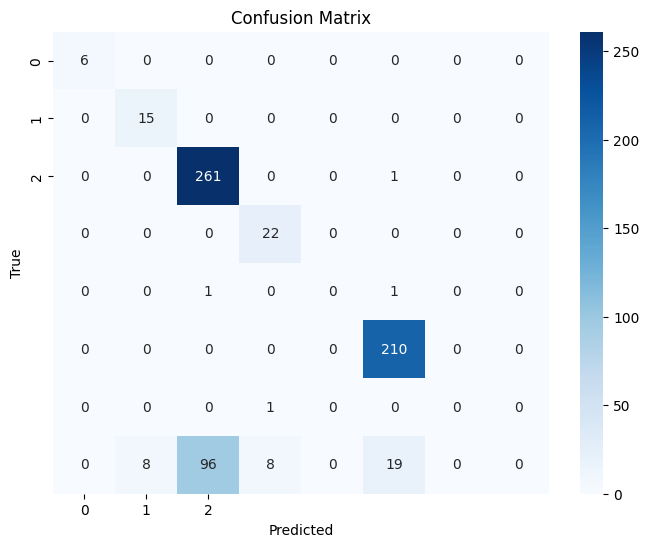

In [174]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example true labels and predicted labels
true_labels = df['true label']
predicted_labels = df['predicted label']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()